In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.stats import iqr
import seaborn as sns

plt.style.use('fivethirtyeight')

# Using unix time

In [2]:
df = pd.read_csv('./dengue.csv')
df.head()

,Time,dengue-sg
0,9.472900e+11,17
1,9.478940e+11,10
2,9.484990e+11,15
3,9.491040e+11,15
4,9.497090e+11,13


In [3]:
# The time delta are roughly +/- 1 hour from the a week's time (604.8e6)
# so we just check that the time deltas are within the week, i.e., not
# delayed by more than half a week
df["Time"].diff().between(604.8e6 * 0.5, 604.8e6 * 1.5)[1 :].all()

True

# Using human readable time

In [4]:
df2 = pd.read_csv('./dengue_human_times.csv', index_col=[0], parse_dates=[0])
df2.head()

,dengue-sg
Time,
2000-01-08,17
2000-01-15,10
2000-01-22,15
2000-01-29,15
2000-02-05,13


In [5]:
np.isclose(df2.index.to_series().diff().dt.days.div(7)[1 :], 1.0).all()

True

# Find head and tail of data

In [6]:
big_df = pd.read_csv("./multicoldataall.csv", index_col=[0], parse_dates=[0]).replace("-", np.nan).astype(float)
big_df.head()

,dengue-sg,temperature-admiralty-avg,temperature-ang-mo-kio-avg,temperature-boon-lay-east-avg,temperature-changi-avg,temperature-choa-chu-kang-south-avg,temperature-clementi-avg,temperature-east-coast-parkway-avg,temperature-jurong-island-avg,temperature-khatib-avg,...,rainfall-toa-payoh-consecutive,rainfall-tuas-consecutive,rainfall-tuas-south-consecutive,rainfall-tuas-west-consecutive,rainfall-ulu-pandan-consecutive,rainfall-upper-peirce-reservoir-consecutive,rainfall-upper-thomson-consecutive,rainfall-whampoa-consecutive,rainfall-yishun-consecutive,population-sg
human-times,,,,,,,,,,,,,,,,,,,,,
2000-01-08,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3960235.7
2000-01-15,10.0,NaN,NaN,NaN,26.3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,3961557.6
2000-01-22,15.0,NaN,NaN,NaN,26.4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,3962880.4
2000-01-29,15.0,NaN,NaN,NaN,26.1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,0.0,NaN,NaN,3964203.2
2000-02-05,13.0,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,3965526.0


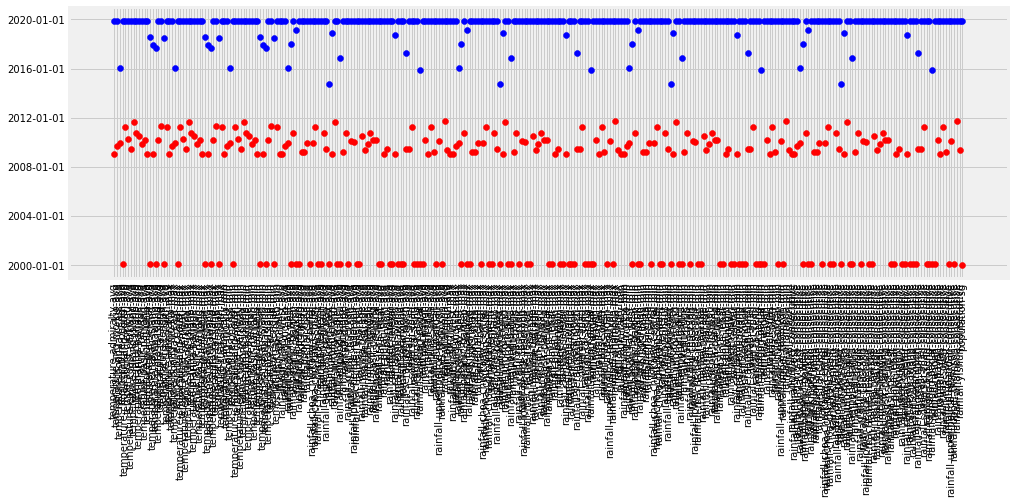

In [7]:
data = {}
for colname in big_df.columns:
    n = big_df[colname].shape[0]
    data[colname] = {}
    res_string = colname
    for i in range(n):
        if not pd.isna(big_df[colname][i]):
            res_string += ";{}".format(big_df.index[i])
            data[colname]["start"] = big_df.index[i]
            break
    for i in range(n):
        j = n - 1 - i
        if not pd.isna(big_df[colname][j]):
            res_string += ";{}".format(big_df.index[j])
            data[colname]["end"] = big_df.index[j]
            break

# for k in data:
#     print("{};{};{}".format(k, data[k]["start"], data[k]["end"]))

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

xfmt = md.DateFormatter('%Y-%m-%d')
ax.yaxis.set_major_formatter(xfmt)
ax.yaxis_date()
ax.scatter(list(data.keys())[1 :], [data[k]["start"] for k in data][1 :], c="r")
ax.scatter(list(data.keys())[1 :], [data[k]["end"] for k in data][1 :], c="b")

plt.xticks(rotation=90)
plt.show()

# Group to regions

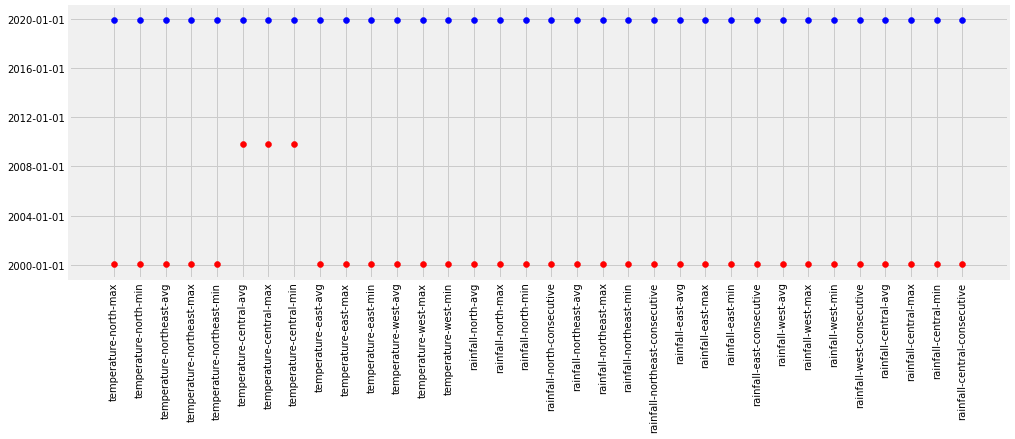

In [8]:
base_regions = {
    "temperature-north": ["temperature-admiralty", "temperature-khatib", "temperature-sembawang"],
    "temperature-northeast": ["temperature-ang-mo-kio", "temperature-seletar", "temperature-tai-seng"],
    "temperature-central": ["temperature-marina-barrage", "temperature-newton", "temperature-sentosa-island"],
    "temperature-east": ["temperature-changi", "temperature-east-coast-parkway", "temperature-pulau-ubin"],
    "temperature-west": ["temperature-boon-lay-east", "temperature-choa-chu-kang-south", "temperature-clementi",
                         "temperature-jurong-island", "temperature-pasir-panjang", "temperature-semakau-island",
                         "temperature-tengah", "temperature-tuas-south"],
    "rainfall-north": ["rainfall-admiralty", "rainfall-admiralty-west", "rainfall-khatib",
                       "rainfall-kranji-reservoir", "rainfall-lim-chu-kang", "rainfall-mandai",
                       "rainfall-sembawang", "rainfall-yishun"],
    "rainfall-northeast": ["rainfall-ang-mo-kio", "rainfall-buangkok", "rainfall-lower-peirce-reservoir",
                           "rainfall-punggol", "rainfall-seletar", "rainfall-serangoon",
                           "rainfall-serangoon-north", "rainfall-tai-seng", "rainfall-upper-peirce-reservoir",
                           "rainfall-upper-thomson"],
    "rainfall-east": ["rainfall-chai-chee", "rainfall-changi", "rainfall-east-coast-parkway",
                      "rainfall-pasir-ris-central", "rainfall-pasir-ris-west", "rainfall-paya-lebar",
                      "rainfall-pulau-ubin", "rainfall-simei", "rainfall-tanjong-katong"],
    "rainfall-west": ["rainfall-boon-lay-east", "rainfall-boon-lay-west", "rainfall-bukit-panjang",
                      "rainfall-choa-chu-kang-central", "rainfall-choa-chu-kang-south",
                      "rainfall-choa-chu-kang-west", "rainfall-clementi", "rainfall-jurong-east",
                      "rainfall-jurong-north", "rainfall-jurong-island", "rainfall-jurong-pier",
                      "rainfall-kent-ridge", "rainfall-pasir-panjang", "rainfall-semakau-island",
                      "rainfall-tengah", "rainfall-tuas", "rainfall-tuas-south", "rainfall-tuas-west"],
    "rainfall-central": ["rainfall-botanic-garden", "rainfall-bukit-timah", "rainfall-buona-vista",
                         "rainfall-dhoby-ghaut", "rainfall-kampong-bahru", "rainfall-macritchie-reservoir",
                         "rainfall-marina-barrage", "rainfall-marine-parade", "rainfall-newton",
                         "rainfall-nicoll-highway", "rainfall-queenstown", "rainfall-sentosa-island",
                         "rainfall-somerset-road", "rainfall-tanjong-pagar", "rainfall-toa-payoh",
                         "rainfall-ulu-pandan", "rainfall-whampoa"]
}
temperature_suffix = ["avg", "max", "min"]
rainfall_suffix = ["avg", "max", "min", "consecutive"]
regions = {f"{k}-{suffix}": [f"{loc}-{suffix}" for loc in base_regions[k]]
           for k in base_regions
           for suffix in (temperature_suffix if "temperature" in k else rainfall_suffix)}

region_head_tail = {}
for k in regions:
    region_head_tail[k] = {}
    region_head_tail[k]["start"] = min(data[loc]["start"] for loc in regions[k])
    region_head_tail[k]["end"] = max(data[loc]["end"] for loc in regions[k])

f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

xfmt = md.DateFormatter('%Y-%m-%d')
ax.yaxis.set_major_formatter(xfmt)
ax.yaxis_date()
ax.scatter(list(region_head_tail.keys())[1 :], [region_head_tail[k]["start"] for k in region_head_tail][1 :], c="r")
ax.scatter(list(region_head_tail.keys())[1 :], [region_head_tail[k]["end"] for k in region_head_tail][1 :], c="b")

plt.xticks(rotation=90)
plt.show()

# Spacial average and normalize population

In [9]:
def describe_column(target_df, colname):
    print(f"{colname} range: ", target_df[colname].max() - target_df[colname].min())
    print(f"{colname} mean: ", target_df[colname].mean())

describe_column(big_df, "dengue-sg")
dengue_offset = 150
dengue_scale = 880 / 2

big_df["dengue-sg-normalized"] = (big_df["dengue-sg"] - dengue_offset) / dengue_scale
describe_column(big_df, "dengue-sg-normalized")

describe_column(big_df, "population-sg")
population_offset = 4800000
population_scale = 1730000 / 2

big_df["population-sg-normalized"] = (big_df["population-sg"] - population_offset) / population_scale
describe_column(big_df, "population-sg-normalized")

for region in regions:
    # mean(axis=1) accounts for nan and doesn't add count to it
    big_df[region] = big_df[regions[region]].mean(axis=1)

dengue-sg range:  888.0
dengue-sg mean:  154.16763005780348
dengue-sg-normalized range:  2.018181818181818
dengue-sg-normalized mean:  0.009471886495007862
population-sg range:  1736577.2999999998
population-sg mean:  4865127.161078998
population-sg-normalized range:  2.0076038150289017
population-sg-normalized mean:  0.0752915156982635


# Extrapolating missing past data

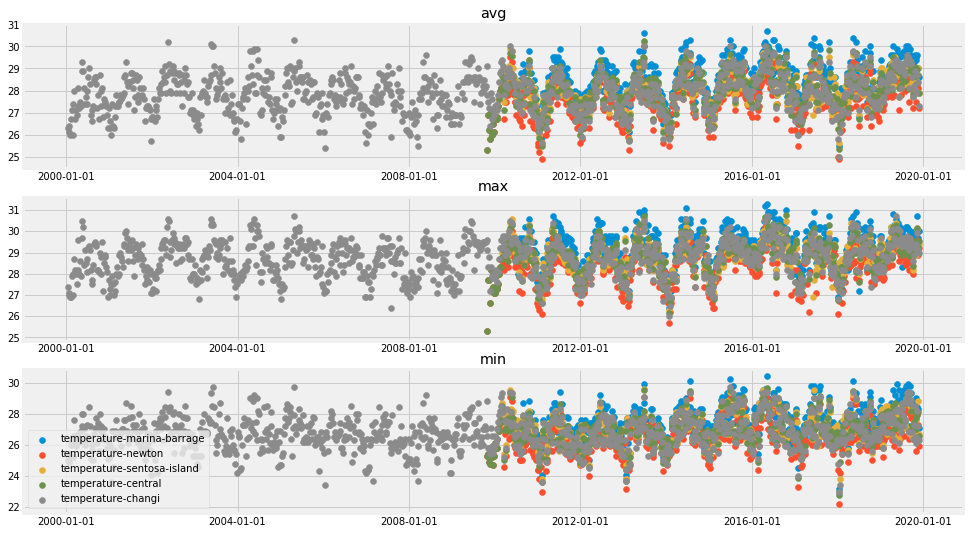

In [10]:
f, ax = plt.subplots(3, 1)
f.set_figheight(9)
f.set_figwidth(15)

xfmt = md.DateFormatter('%Y-%m-%d')
for ax, suffix in zip(ax, ["avg", "max", "min"]):
    ax.title.set_text(suffix)
    ax.xaxis.set_major_formatter(xfmt)
    ax.xaxis_date()
    ax.scatter(big_df.index, big_df[f"temperature-marina-barrage-{suffix}"], label="temperature-marina-barrage")
    ax.scatter(big_df.index, big_df[f"temperature-newton-{suffix}"], label="temperature-newton")
    ax.scatter(big_df.index, big_df[f"temperature-sentosa-island-{suffix}"], label="temperature-sentosa-island")

    ax.scatter(big_df.index, big_df[f"temperature-central-{suffix}"], label="temperature-central")
    ax.scatter(big_df.index, big_df[f"temperature-changi-{suffix}"], label="temperature-changi")
plt.legend()
plt.show()

### Using only the first 5 "normal" years to average

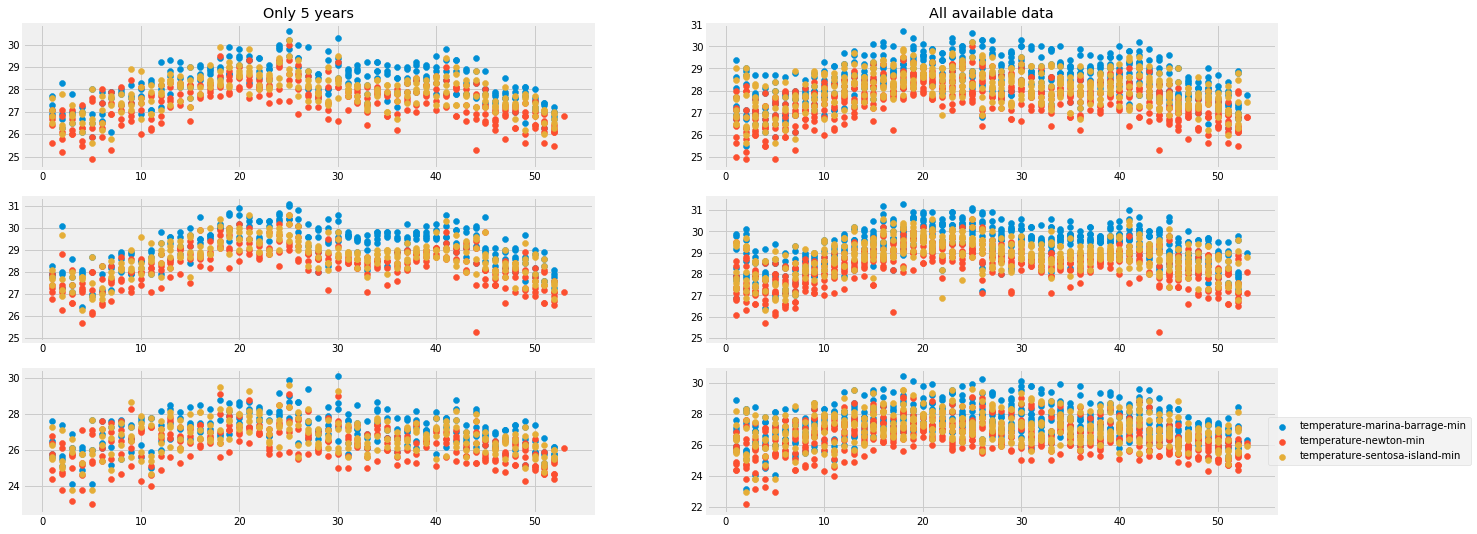

In [11]:
df_central = big_df[regions[f"temperature-central-avg"] + regions[f"temperature-central-max"] +
                    regions[f"temperature-central-min"]].copy()
df_central["weekofyear"] = df_central.index.weekofyear
# df_central_dict = {k: big_df[regions[f"temperature-central-{k}"]].copy() for k in ["avg", "max", "min"]}
# for k in df_central_dict:
#     df_central_dict[k]["weekofyear"] = df_central_dict[k].index.weekofyear

# df_central = big_df[regions["temperature-central-avg"]].copy()
# df_central['weekofyear'] = df_central.index.weekofyear

f, ax = plt.subplots(3, 2)
f.set_figheight(9)
f.set_figwidth(20)

five_normal_years = (df_central.index > '2009-10-25') & (df_central.index <= "2015-1-1")
ax[0][0].title.set_text("Only 5 years")
ax[0][1].title.set_text("All available data")
for i, suffix in enumerate(temperature_suffix):
    for colname in regions[f"temperature-central-{suffix}"]:
        ax[i][0].scatter(df_central["weekofyear"].loc[five_normal_years],
                         df_central[colname].loc[five_normal_years],
                         label=colname)
        ax[i][1].scatter(df_central["weekofyear"], df_central[colname], label=colname)
# for colname in regions["temperature-central-avg"]:
#     ax1.scatter(df_central["weekofyear"].loc[five_normal_years], df_central[colname].loc[five_normal_years],
#                 label=colname)
#     ax2.scatter(df_central["weekofyear"], df_central[colname], label=colname)

# for colname in regions["temperature-central-avg"]:
#     ax1.scatter(df_central["weekofyear"].loc[five_normal_years], df_central[colname].loc[five_normal_years],
#                 label=colname)
#     ax2.scatter(df_central["weekofyear"], df_central[colname], label=colname)

plt.legend(loc=7, bbox_to_anchor=(1.35, 0.5))
plt.show()

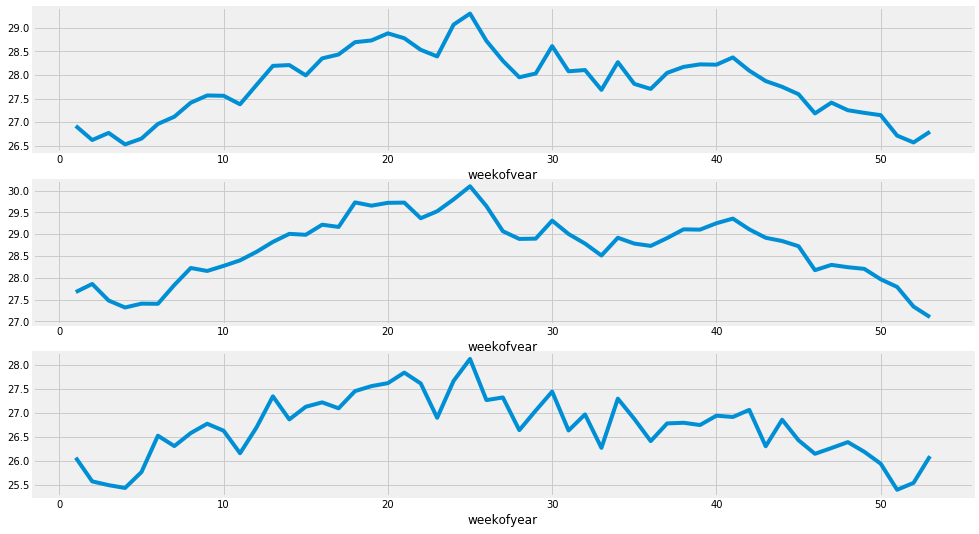

In [12]:
five_year_mean = {suffix: df_central[regions[f"temperature-central-{suffix}"] + ["weekofyear"]]  \
                          .loc[five_normal_years].groupby(["weekofyear"]).mean().mean(axis=1)
                  for suffix in temperature_suffix}

f, ax = plt.subplots(3, 1)
f.set_figheight(9)
f.set_figwidth(15)

for i, suffix in enumerate(temperature_suffix):
    five_year_mean[suffix].plot(ax=ax[i])

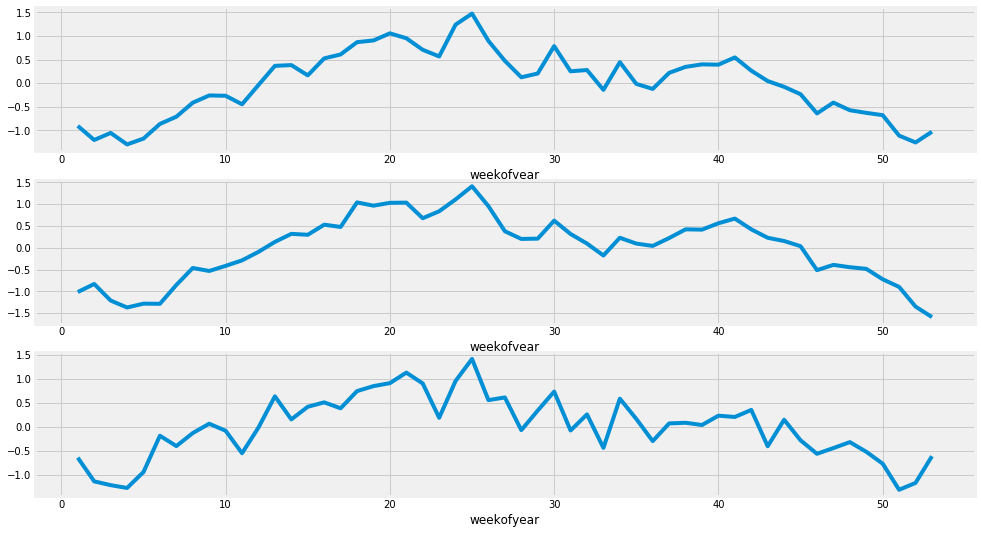

In [13]:
five_year_offset = {k: five_year_mean[k] - five_year_mean[k].mean() for k in five_year_mean}

f, ax = plt.subplots(3, 1)
f.set_figheight(9)
f.set_figwidth(15)

for i, suffix in enumerate(temperature_suffix):
    five_year_offset[suffix].plot(ax=ax[i])

### Extrapolate with no scaling

In [14]:
for suffix in temperature_suffix:
    df_central_mean = big_df[[f"temperature-central-{suffix}"]].copy()
    df_central_mean[f"temperature-changi-{suffix}"] = big_df[f"temperature-changi-{suffix}"]
    df_central_mean["weekofyear"] = df_central_mean.index.weekofyear
    df_central_mean["year"] = df_central_mean.index.year

    mean_by_year = df_central_mean.groupby("year").mean()[f"temperature-changi-{suffix}"]
    missing_years = (df_central.index < '2009-10-25')
    for i in range(df_central_mean.shape[0]):
        if missing_years[i]:
            year = df_central_mean.loc[missing_years]["year"][i]
            weekofyear = df_central_mean.loc[missing_years]["weekofyear"][i]
            temp = mean_by_year[year] + five_year_offset[suffix][weekofyear]
            df_central_mean.at[df_central_mean.index[i], f"temperature-central-{suffix}"] = temp
    big_df[f"temperature-central-{suffix}-filled"] = df_central_mean[f"temperature-central-{suffix}"].copy()

In [15]:
for suffix in temperature_suffix:
    df_central_mean = big_df[[f"temperature-central-{suffix}"]].copy()
    df_central_mean[f"temperature-changi-{suffix}"] = big_df[f"temperature-changi-{suffix}"]
    df_central_mean["weekofyear"] = df_central_mean.index.weekofyear
    df_central_mean["year"] = df_central_mean.index.year
    five_year_iqr = iqr(df_central.loc[five_normal_years].groupby(["weekofyear"]).mean().mean(axis=1))

    mean_by_year = df_central_mean.groupby("year").mean()[f"temperature-changi-{suffix}"]
    missing_years = (df_central.index < '2009-10-25')
    for i in range(df_central_mean.shape[0]):
        if missing_years[i]:
            year = df_central_mean.loc[missing_years]["year"][i]
            curr_iqr = iqr(df_central_mean[df_central_mean["year"] == year][f"temperature-changi-{suffix}"],
                           nan_policy="omit")
            weekofyear = df_central_mean.loc[missing_years]["weekofyear"][i]
            temp = mean_by_year[year] + five_year_offset[suffix][weekofyear] * curr_iqr / five_year_iqr
            df_central_mean.at[df_central_mean.index[i], f"temperature-central-{suffix}"] = temp
    big_df[f"temperature-central-{suffix}-scaled"] = df_central_mean[f"temperature-central-{suffix}"].copy()

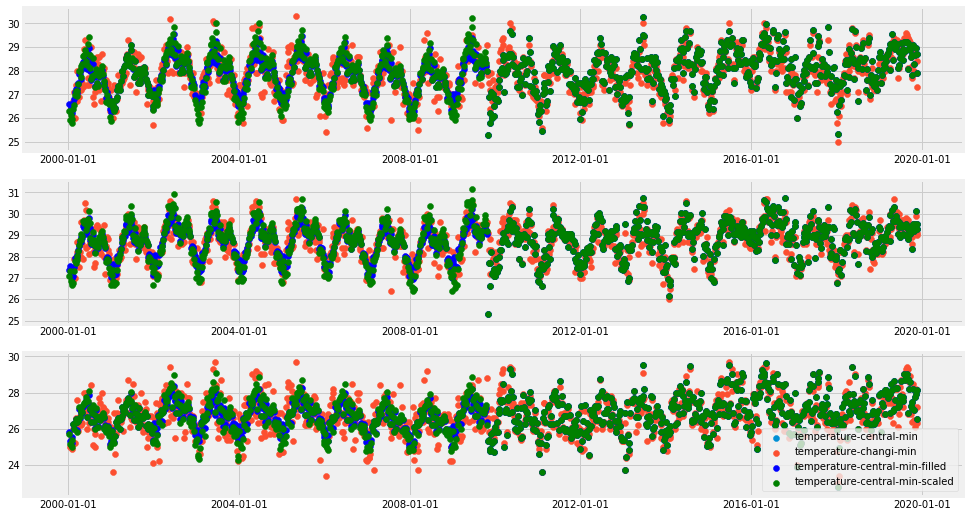

In [16]:
f, ax = plt.subplots(3, 1)
f.set_figheight(9)
f.set_figwidth(15)

xfmt = md.DateFormatter('%Y-%m-%d')
for i, suffix in enumerate(temperature_suffix):
    ax[i].xaxis.set_major_formatter(xfmt)
    ax[i].xaxis_date()

    ax[i].scatter(big_df.index, big_df[f"temperature-central-{suffix}"],
                  label=f"temperature-central-{suffix}")
    ax[i].scatter(big_df.index, big_df[f"temperature-changi-{suffix}"],
                  label=f"temperature-changi-{suffix}")
    ax[i].scatter(big_df.index, big_df[f"temperature-central-{suffix}-filled"], c="b",
                  label=f"temperature-central-{suffix}-filled")
    ax[i].scatter(big_df.index, big_df[f"temperature-central-{suffix}-scaled"], c="g",
                  label=f"temperature-central-{suffix}-scaled")

plt.legend()
plt.show()

# Temperature by region

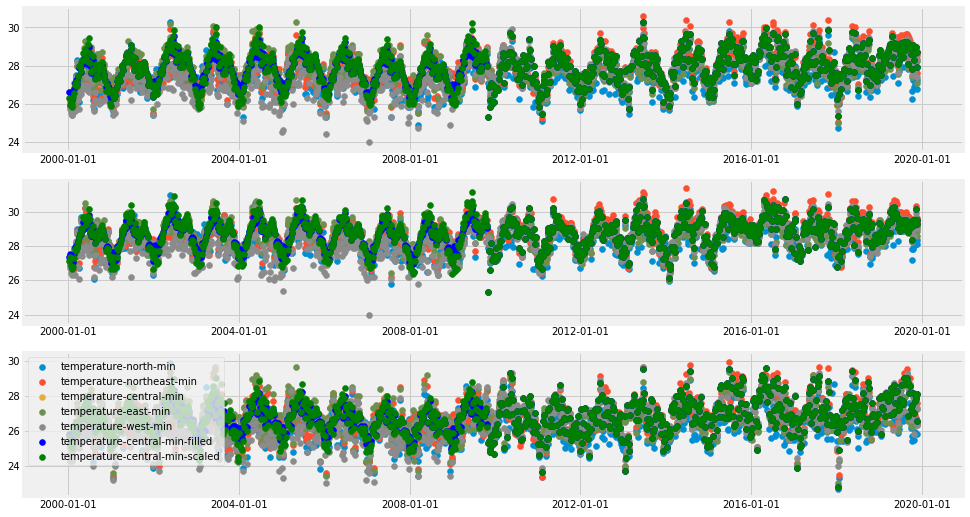

In [17]:
f, ax = plt.subplots(3, 1)
f.set_figheight(9)
f.set_figwidth(15)

xfmt = md.DateFormatter('%Y-%m-%d')
for i, suffix in enumerate(temperature_suffix):
    ax[i].xaxis.set_major_formatter(xfmt)
    ax[i].xaxis_date()

    for region in regions:
        if "temperature" in region and suffix in region:
            ax[i].scatter(big_df.index, big_df[region], label=region)
    ax[i].scatter(big_df.index, big_df[f"temperature-central-{suffix}-filled"], c="b",
                  label=f"temperature-central-{suffix}-filled")
    ax[i].scatter(big_df.index, big_df[f"temperature-central-{suffix}-scaled"], c="g",
                  label=f"temperature-central-{suffix}-scaled")
plt.legend()
plt.show()

# Rainfall by region

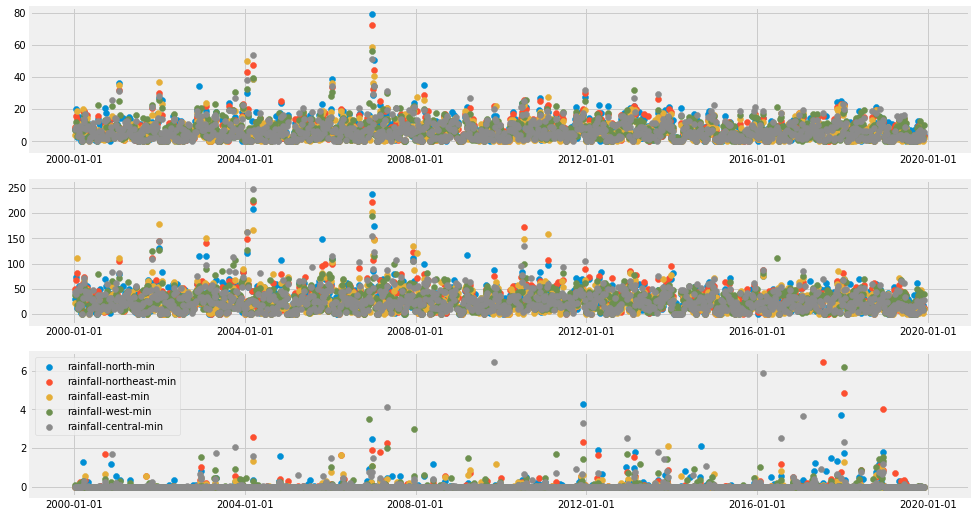

In [18]:
f, ax = plt.subplots(3, 1)
f.set_figheight(9)
f.set_figwidth(15)


xfmt = md.DateFormatter('%Y-%m-%d')
for i, suffix in enumerate(temperature_suffix):
    ax[i].xaxis.set_major_formatter(xfmt)
    ax[i].xaxis_date()

    for region in regions:
        if "rainfall" in region and suffix in region:
            ax[i].scatter(big_df.index, big_df[region], label=region)
plt.legend()
plt.show()

# Interpolate

In [19]:
for suffix in temperature_suffix:
    for colname in ["temperature-north", "temperature-northeast", "temperature-east", "temperature-west"]:
        big_df[f"{colname}-{suffix}"] = big_df[f"{colname}-{suffix}"].interpolate()

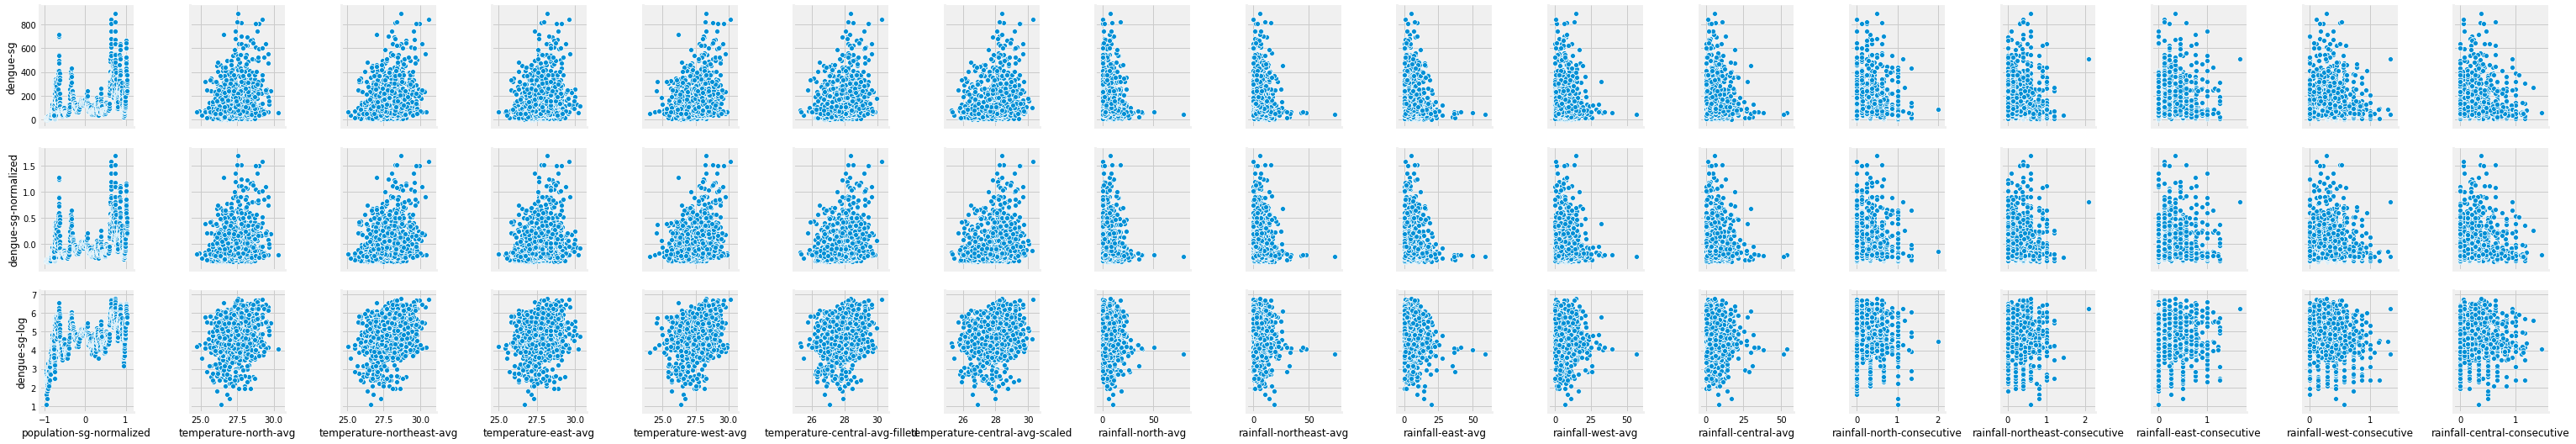

In [52]:
input_df = big_df[["dengue-sg", "dengue-sg-normalized", "population-sg-normalized",
                   "temperature-north-avg", "temperature-northeast-avg", "temperature-east-avg",
                   "temperature-west-avg", "temperature-central-avg-filled", "temperature-central-avg-scaled",
                   "temperature-north-max", "temperature-northeast-max", "temperature-east-max",
                   "temperature-west-max", "temperature-central-max-filled", "temperature-central-max-scaled",
                   "temperature-north-min", "temperature-northeast-min", "temperature-east-min",
                   "temperature-west-min", "temperature-central-min-filled", "temperature-central-min-scaled",
                   "rainfall-north-avg", "rainfall-northeast-avg", "rainfall-east-avg", "rainfall-west-avg",
                   "rainfall-central-avg",
                   "rainfall-north-max", "rainfall-northeast-max", "rainfall-east-max", "rainfall-west-max",
                   "rainfall-central-max",
                   "rainfall-north-min", "rainfall-northeast-min", "rainfall-east-min", "rainfall-west-min",
                   "rainfall-central-min",
                   "rainfall-north-consecutive", "rainfall-northeast-consecutive", "rainfall-east-consecutive",
                   "rainfall-west-consecutive", "rainfall-central-consecutive"]].copy()
input_df["dengue-sg-log"] = np.log(big_df["dengue-sg"])

sns.pairplot(input_df,
             x_vars=["population-sg-normalized",
                     "temperature-north-avg", "temperature-northeast-avg", "temperature-east-avg",
                     "temperature-west-avg", "temperature-central-avg-filled", "temperature-central-avg-scaled",
#                      "temperature-north-max", "temperature-northeast-max", "temperature-east-max",
#                      "temperature-west-max", "temperature-central-max-filled", "temperature-central-max-scaled",
#                      "temperature-north-min", "temperature-northeast-min", "temperature-east-min",
#                      "temperature-west-min", "temperature-central-min-filled", "temperature-central-min-scaled",
                     "rainfall-north-avg", "rainfall-northeast-avg", "rainfall-east-avg", "rainfall-west-avg",
                     "rainfall-central-avg",
#                      "rainfall-north-max", "rainfall-northeast-max", "rainfall-east-max", "rainfall-west-max",
#                      "rainfall-central-max",
#                      "rainfall-north-min", "rainfall-northeast-min", "rainfall-east-min", "rainfall-west-min",
#                      "rainfall-central-min",
                     "rainfall-north-consecutive", "rainfall-northeast-consecutive", "rainfall-east-consecutive",
                     "rainfall-west-consecutive", "rainfall-central-consecutive"],
             y_vars=["dengue-sg", "dengue-sg-normalized", "dengue-sg-log"])

In [53]:
big_df.to_csv("multicoldata_extrapolated.csv")
input_df.to_csv("input_data.csv")
input_df.head()

,dengue-sg,dengue-sg-normalized,population-sg-normalized,temperature-north-avg,temperature-northeast-avg,temperature-east-avg,temperature-west-avg,temperature-central-avg-filled,temperature-central-avg-scaled,temperature-north-max,...,rainfall-northeast-min,rainfall-east-min,rainfall-west-min,rainfall-central-min,rainfall-north-consecutive,rainfall-northeast-consecutive,rainfall-east-consecutive,rainfall-west-consecutive,rainfall-central-consecutive,dengue-sg-log
human-times,,,,,,,,,,,,,,,,,,,,,
2000-01-08,17.0,-0.302273,-0.970826,NaN,NaN,NaN,NaN,26.594192,26.316731,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.833213
2000-01-15,10.0,-0.318182,-0.969298,25.9,26.1,26.3,25.7,26.295859,25.926815,26.9,...,0.0,0.0,0.1,0.0,0.000000,0.2,1.00,0.571429,0.333333,2.302585
2000-01-22,15.0,-0.306818,-0.967768,25.9,26.1,26.4,25.5,26.445859,26.122862,26.8,...,0.0,0.0,0.0,0.0,0.000000,0.4,0.00,0.285714,0.000000,2.708050
2000-01-29,15.0,-0.306818,-0.966239,25.9,26.1,26.1,25.4,26.202526,25.804831,26.7,...,0.0,0.0,0.0,0.0,0.666667,1.0,0.75,0.857143,0.333333,2.708050
2000-02-05,13.0,-0.311364,-0.964710,25.7,26.1,26.0,25.4,26.325859,25.966025,26.9,...,0.0,0.0,0.0,0.0,0.666667,0.6,0.50,0.142857,0.333333,2.564949


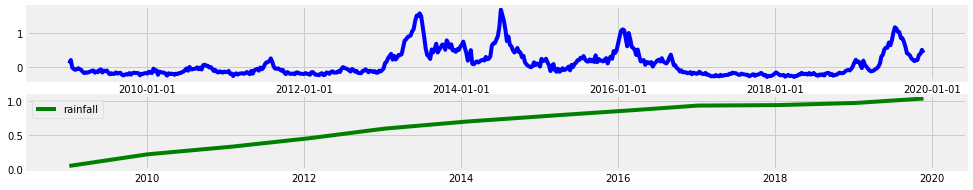

In [54]:
f, ax = plt.subplots(2, 1)
f.set_figheight(3)
f.set_figwidth(15)

last_ten_years = (input_df.index > '2009-01-01')

xfmt = md.DateFormatter('%Y-%m-%d')
ax[0].xaxis.set_major_formatter(xfmt)
ax[0].xaxis_date()

ax[0].plot(input_df.loc[last_ten_years].index, input_df.loc[last_ten_years]["dengue-sg-normalized"], c="b",
              label="dengue")
# ax[1].plot(input_df.loc[last_ten_years].index, input_df.loc[last_ten_years]["rainfall-north-consecutive"] +
#            input_df.loc[last_ten_years]["rainfall-northeast-consecutive"] +
#            input_df.loc[last_ten_years]["rainfall-east-consecutive"] +
#            input_df.loc[last_ten_years]["rainfall-west-consecutive"] +
#            input_df.loc[last_ten_years]["rainfall-central-consecutive"],
#            c="g", label="rainfall")
ax[1].plot(input_df.loc[last_ten_years].index, input_df.loc[last_ten_years]["population-sg-normalized"],
           c="g", label="rainfall")
plt.legend()
plt.show()